# Evaluacion de Resultados.

En este notebook se muestran tecnicas para la evaluación de los resultados de una predicción con un algoritmo de ML.

#### Descripción

NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods.

Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Ficheros de Datos.

* <span style ="color:green" >**KDDTrain+.ARFF:** The full NSL-KDD train set with binary labels in ARFF format.</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format.
* KDDTrain+_20Percent.ARFF: A 20% subset of the KDDTrain+.arff file.
* KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format.
* KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format.
* KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21.
* KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21.

### Descarga de los ficheros de datos.
https://www.unb.ca/cic/datasets/index.html

### Referencias adicionales sobre el conjunto de datos.
_M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._


## Imports

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones Auxiliares.

In [2]:
def load_kdd_dataset(data_path):
    """Lectura del DataSet NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [3]:
# Construccion de una funcion de particionado que realize el particionado completo
def train_val_test_split(df, rstate=4, shuffle = True, stratify = None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        #modifique el 0.4 por 0.51
    df, test_size = 0.100, random_state = rstate, shuffle=shuffle, stratify = strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        #de 200 a 0.2202
    test_set, test_size = 0.2502, random_state = rstate, shuffle = shuffle, stratify=strat)
    return(train_set, val_set, test_set)

In [4]:
# Construccion de un pipeline para los atributos numericos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('rbst_scaler', RobustScaler()),
])

In [2]:
# Transform para codificar unicamente las columnas categoricas y devolver un DatFrame.
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse = None)
        self._columns = None
    def fit(self, X, y = None):
        X_cat = X.select_dtypes(include = ['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y = None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include = ['object'])
        X_num = X_copy.select_dtypes(include = ['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                               columns = self._columns,
                               index = X_copy.index)
        X_copy.drop(list(X_cat), axis = 1, inplace = True)
        return X_copy.join(X_cat_oh)

NameError: name 'BaseEstimator' is not defined

In [6]:
# Transformador que prepara todo el DataSet llamada Pipeline y transformadores personalizados.
class DataFramePrepare(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y = None):
        num_attribs = list(X.select_dtypes(exclude = ['object']))
        cat_attribs = list(X.select_dtypes(include = ['object']))
        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y = None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep,
                            columns = self._columns,
                            index = X_copy.index)

## Lectura del Dataset

In [7]:
df = load_kdd_dataset("datasets/NSL-KDD/KDDTrain+.arff")

In [8]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## Division del DataSet

In [9]:
# Division del dataset en los diferentes subconjuntos.
train_set, val_set, test_set = train_val_test_split(df, stratify='protocol_type')

In [10]:
print("Longitud del Training Set: ", len(train_set))
print("Longitud de Validacion del Set: ", len(val_set))
print("Longitud del Test Set: ", len(test_set))

Longitud del Training Set:  113375
Longitud de Validacion del Set:  9445
Longitud del Test Set:  3153


Para cada uno de los subconjuntos, se separa las etiquetas de las caracteristicas de entrada. 

In [11]:
# Conjunto de datos general 
X_df = df.drop("class", axis = 1)
y_df = df["class"].copy()

In [12]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis = 1)
y_train = train_set["class"].copy()

In [13]:
#Conjunto de validacion
X_val = val_set.drop("class", axis = 1)
y_val = val_set["class"].copy()

In [14]:
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis = 1)
y_test = test_set["class"].copy()

## Preparacion del DataSet

In [15]:
# Instanciar el transformador personalizado
data_preparer = DataFramePrepare()

In [16]:
# Ajustar con fit el DataSet general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

DataFramePrepare()

In [17]:
# Ajustar con fit el DataSet general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

In [18]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
57645,0.0,udp,other,SF,1.0,0.0,0,0.0,0.0,0.0,...,255.0,8.0,0.03,0.05,1.0,0.0,0.0,0.0,0.0,0.0
18240,0.0,tcp,http,SF,368.0,451.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
108683,0.0,tcp,http,SF,236.0,943.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
99501,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,132.0,1.00,0.00,1.0,0.5,0.0,0.0,0.0,0.0
92233,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,25.0,0.10,0.06,0.0,0.0,1.0,1.0,0.0,0.0


In [19]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
57645,0.0,-0.155797,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
18240,0.0,1.173913,0.874031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
108683,0.0,0.695652,1.827519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
99501,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
92233,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [20]:
X_val_prep = data_preparer.transform(X_val)

In [21]:
X_val_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
20917,0.0,0.706522,0.529070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
40838,0.0,0.365942,28.414729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
51401,0.0,1.050725,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
104925,0.0,-0.086957,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
25731,0.0,0.634058,0.486434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Entranamiento de un algoritmo de regresión Logística.

La instanciacion de un algoritmo de ML utilizando Sklearn se realiza utilizando los metodos expuestos por la API de Sklearn tal como se ha presentado en cuadernos anteriores

In [22]:
# Entrenamiento un algoritmo basado en Regresion Logistica
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 20000)
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=20000)

## Prediccion de nuevos ejemplos.

Realizar una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de regresión Logística. Se utilizará el subconjunto de validación. 

In [23]:
y_pred = clf.predict(X_val_prep)

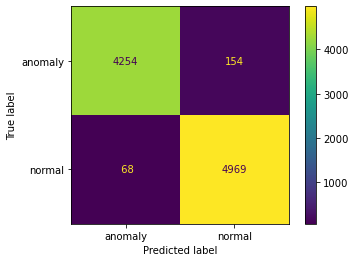

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format = '3g')

## 2.-Métricas derivadas de la matriz de confusión.

PRESICIÓN.

In [25]:
from sklearn.metrics import precision_score

print("presición: ", precision_score(y_val, y_pred, pos_label= 'anomaly'))

presición:  0.984266543267006


In [26]:
from sklearn.metrics import recall_score

print("Recall: ", recall_score(y_val, y_pred, pos_label= 'anomaly'))

Recall:  0.9650635208711433


### F1 Score.

In [27]:
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(y_val, y_pred, pos_label= 'anomaly'))


F1 Score:  0.9745704467353952


## 3.- Curvas ROC Y PR.

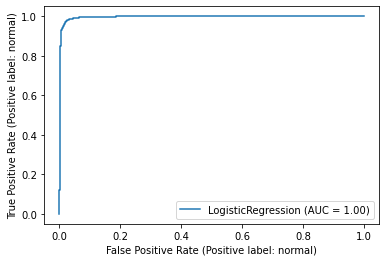

In [28]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_val_prep, y_val)

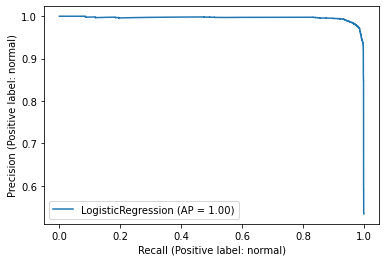

In [29]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf, X_val_prep, y_val)

## 4.- Evaluación del modelo con el DataSet de pruebas.


In [30]:
# Transformamos el subconjunto de datos de validación 
X_test_prep = data_preparer.transform(X_test)

In [31]:
y_pred = clf.predict(X_test_prep)

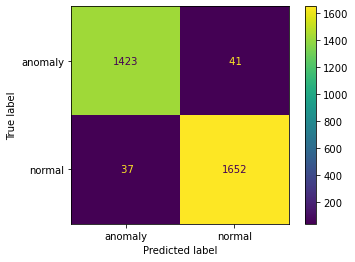

In [32]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix (clf, X_test_prep, y_test, values_format='3g')